In [14]:
# Preambulo do projeto
# Importações dos pacotes necessários
import gym, math, tqdm, numpy as np, matplotlib.pyplot as plt, statistics as st
from scipy.stats import norm

In [15]:
# Criando o ambiente
env_name = "MountainCar-v0"
env = gym.make(env_name)

In [16]:
# Isso é para garantir o mesmo ambiente de execução toda vez.
seed_val = 13 # L
env.seed(seed_val)
np.random.seed(seed_val)

In [17]:
# Definição de parâmetros
discrete = (30, 60)
num_eps = 50000
epsilon, min_epsilon = 0.0, 0.1

# Alpha corresponde à TAXA DE APRENDIZADO
learning_rate, min_learning_rate = 0.0, 0.2

discount_factor = 0.95
dec = 15

# Pode retornar os valores low[] e high[] direto do 'env', mas preferi colocar fixos aqui.
lower = [-1.2, -0.07]
upper = [0.6, 0.07]

# Inicializando a QTable
qtable = np.zeros(discrete + (env.action_space.n, ))

In [18]:
def choose_action(state):
    """
        O fator aleatório para melhorar o aprendizado
    """
    if (np.random.random() < epsilon):
        return env.action_space.sample()
    else:
        return np.argmax(qtable[state])
# ---------------------------------------------------------------------#
def discrete_state(state):
    """
        Recebe um espaço de observação (observation space) e o discretiza
    """
    d = list()

    for i in range(len(state)):
        stepsize = (state[i] + abs(lower[i])) / (upper[i] - lower[i])
        new_state = int(np.round((discrete[i] - 1) * stepsize))
        new_state = min(discrete[i] - 1, max(0, new_state))
        d.append(new_state)

    return tuple(d)
# ---------------------------------------------------------------------#
def get_epsilon(ep):
    # vai reduzindo o epsilon para diminuir a ganância do algoritmo
    # entretando, existe um valor mínimo que não reduz para garantir alguma aleatoriedade
    # reduz à medida que aumenta a quantidade de episódios
    # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    return max(min_epsilon, min(1., 1. - math.log10((ep + 1) / dec)))
# ---------------------------------------------------------------------#
def get_learning_rate(ep):
    # vai reduzindo a taxa de aprendizagem para diminuir a ganância do algoritmo
    # entretando, existe um valor mínimo que não reduz para garantir algum aprendizado
    # reduz à medida que aumenta a quantidade de episódios
    # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    return max(min_learning_rate, min(1., 1. - math.log10((ep + 1) / dec)))
# ---------------------------------------------------------------------#
def update_qtable(state1, action1, reward, state2, action2):
    qtable[state1][action1] += learning_rate * (reward + discount_factor * qtable[state2][action2] - qtable[state1][action1])

In [19]:
# Treinamento

# usado para plotar o gráfico de aprendizado
tr = []

# Treinamento SARSA
for ep in tqdm.tqdm(range(num_eps)):
    state1 = discrete_state(env.reset())
    action1 = choose_action(state1)

    learning_rate = get_learning_rate(ep)
    epsilon = get_epsilon(ep)
    done = False
    
    # usado para plotar o gráfico de aprendizado
    r = []

    while not done:
        # Pega o próximo estado, aka, S'
        obs, reward, done, _ = env.step(action1)
        state2 = discrete_state(obs)
        
        # Escolhe a ação futura baseada no estado futuro observado
        action2 = choose_action(state2)

        # Atualiza a QTable
        update_qtable(state1, action1, reward, state2, action2)

        state1 = state2
        action1 = action2

        r.append(reward)
        # fim WHILE

    env.close()
    tr.append(sum(r))
# fim FOR

100%|██████████| 50000/50000 [07:31<00:00, 110.69it/s]


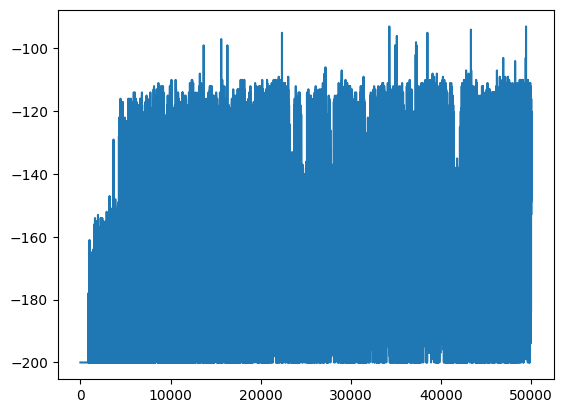

In [20]:
plt.plot(tr)

In [21]:
# Avaliando o treinamento dado

tr = []     # usado para plotar o histograma
i = 0       # macete para renderizar alguns episodios

# executando sempre para 10% de passos sobre o número total de episódios usados para treinamento
for _ in tqdm.tqdm(range(int(num_eps * 0.1))):
    
    # ambiente a ser avaliado
    env_t = gym.make(env_name)
    
    # usado para plotar o gráfico de aprendizado
    r = []

    done = False

    # estado atual
    cs = discrete_state(env_t.reset())

    while not done:
        
        # Renderizar os ultimos 5 episodios
        #if i >= (int(num_eps * 0.1) - 5):
        #    env_t.render()

        action = np.argmax(qtable[cs])
        obs, reward, done, _ = env_t.step(action)
        new_state = discrete_state(obs)
        cs = new_state
        r.append(reward)
        # fim WHILE
        
    i += 1
    env_t.close()
    tr.append(sum(r))
# fim FOR

100%|██████████| 5000/5000 [01:06<00:00, 75.37it/s]


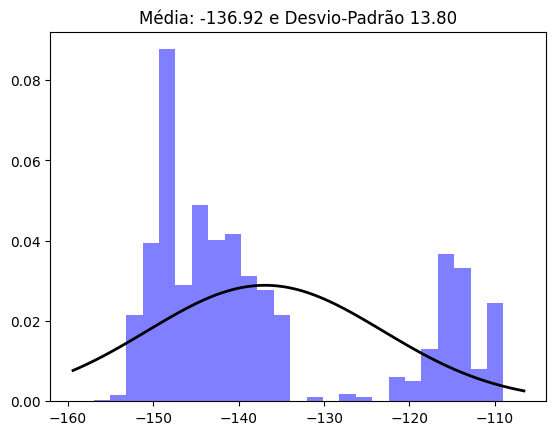

In [22]:
# Calcula MÉDIA e DESVIO-PADRÃO
mu, std  = st.mean(tr), st.stdev(tr)

plt.hist(tr, bins=25, density=True, alpha=0.5, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Média: {:.2f} e Desvio-Padrão {:.2f}".format(mu, std)
plt.title(title)
  
plt.show()